In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from bbplot import bijan
import statsmodels.api as sm
import scipy.stats as stats

# QUESTION 1 : Forecasting Sales for Renault Vehicles

# PART A

In [277]:
temp_df = pd.read_csv("renault.csv", header=None)

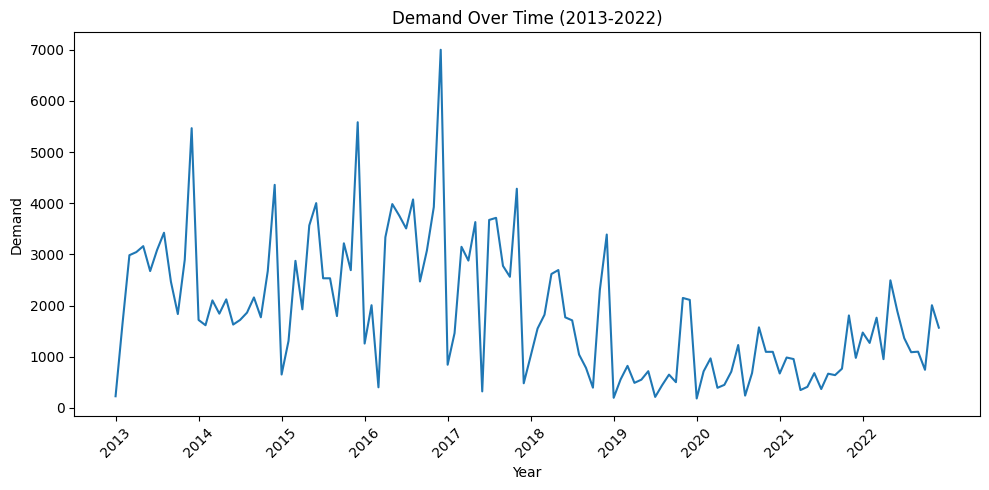

In [278]:
df = pd.DataFrame()
df['Date'] = temp_df.loc[: ,0]
df['Year'] =temp_df.loc[:, 0].apply(lambda x: x.split('-')[0])
df['Demand'] = temp_df.loc[:, 1]
demand = df['Demand']
plt.figure(figsize=(10, 5))
plt.plot(demand)
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title('Demand Over Time (2013-2022)')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

# PART B

Naive Forecasts for Sales

In [279]:
def get_naive_F_series(tau, demand):
    out = []
    for t in range(len(demand)):
        out.append(get_naive_F(tau, demand, t))
    return out

def get_naive_F(tau, demand, t):
    if t + 1 <= tau:
        return None
    return demand[t - tau]

Error Measure Calculating Functions (MAE, MAPE, RMSE and Residuals)

In [280]:
def get_end_time(year, question = 1):
    if question == 1:
        return (year - 2013) * 12 + 11
    return (year - 2010) * 12 + 11


def get_start_time(year, question = 1):
    if question == 1:
        return (year - 2013) * 12
    return (year - 2010) * 12

def is_valid_time(start_year, end_year, t, question = 1):
    return t < get_start_time(start_year, question) or get_end_time(end_year, question) < t

def get_abs_error(demand, forecast, t, start_year, end_year, question=1):
    if forecast[t] is None or np.isnan(forecast[t]):  # Check if forecast value is None or NaN
        return None
    if is_valid_time(start_year, end_year, t, question):
        return None
    return abs(demand.loc[t] - forecast[t])

def get_residuals(demand, forecast, start_year, end_year, question=1):
    out = []
    for t in range(len(demand)):
        if forecast[t] is None or np.isnan(forecast[t]):  # Check if forecast value is None or NaN
            continue
        if is_valid_time(start_year, end_year, t, question):
            continue
        out.append(demand.loc[t] - forecast[t])
    return out

def mean_absolute_error(demand, forecast, start_year, end_year, question=1):
    tot = 0
    count = 0
    for t in range(len(demand)):
        error = get_abs_error(demand, forecast, t, start_year, end_year, question)
        if error is None:
            continue
        count += 1
        tot += error
    return tot / count

def mean_abs_percentage_error(demand, forecast, start_year, end_year, question=1):
    tot = 0
    count = 0
    for t in range(len(demand)):
        error = get_abs_error(demand, forecast, t, start_year, end_year, question)
        if error is None:
            continue
        count += 1
        tot += abs(error / demand.loc[t])
    return 100 * tot / count

def root_mean_squared_error(demand, forecast, start_year, end_year, question=1):
    tot = 0
    count = 0
    for t in range(len(demand)):
        error = get_abs_error(demand, forecast, t, start_year, end_year, question)
        if error is None or np.isnan(error):  # Check if error value is None or NaN
            continue
        count += 1
        tot += error ** 2
    return np.sqrt(tot / count)

def test_residual_mean(residuals, significance_level=0.05):
    t_statistic, p_value = stats.ttest_1samp(residuals, 0)
    if p_value < significance_level:
        result = "Reject the null hypothesis. The mean of residuals is significantly different from zero."
    else:
        result = "Fail to reject the null hypothesis. The mean of residuals could plausibly be zero."
    return result

Naive Forecast for $\tau$ = 1

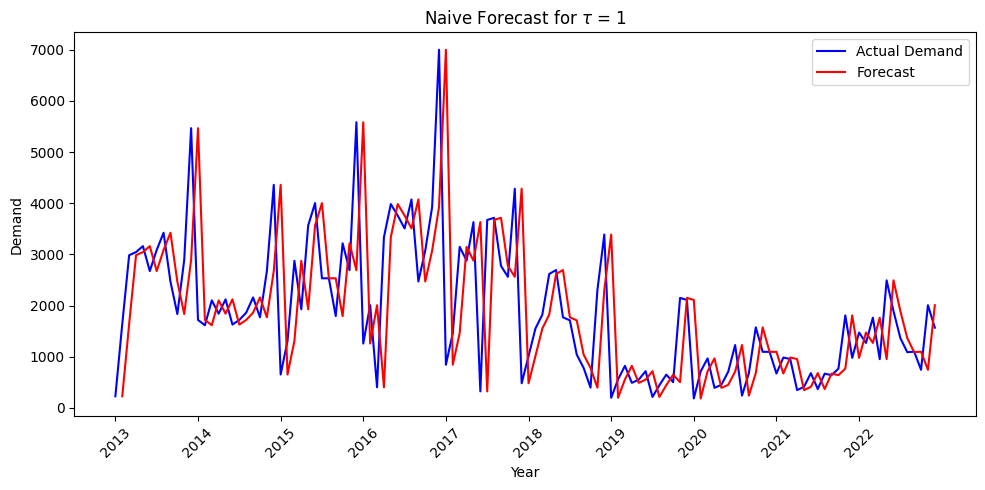

In [281]:
forecast = get_naive_F_series(1, demand)

plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Naive Forecast for $\\tau$ = 1')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.plot(demand, color = "blue", label='Actual Demand')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()

Naive Forecast for $\tau$ = 12

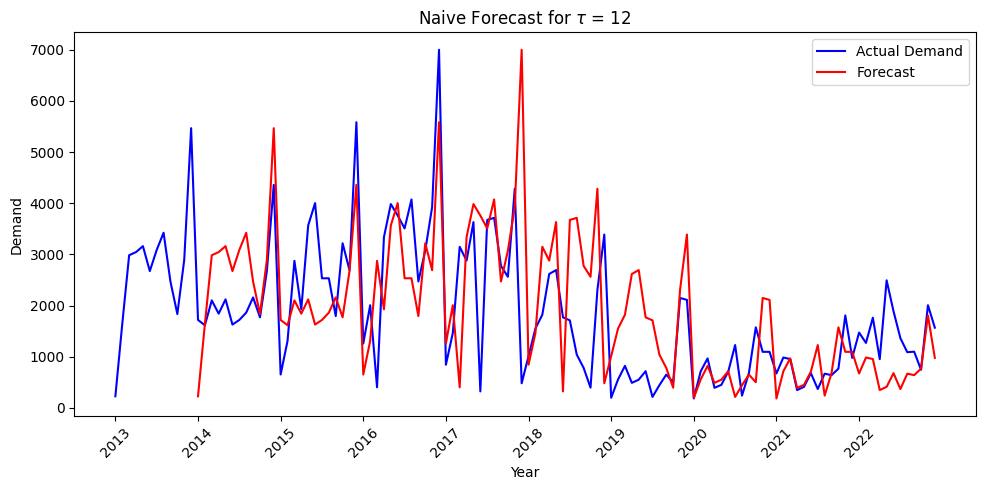

In [282]:
forecast = get_naive_F_series(12, demand)

plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Naive Forecast for $\\tau$ = 12')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.plot(demand, color = "blue", label='Actual Demand')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()

Error Metrics for $\tau$ = 1 and $\tau$ = 12

In [283]:
for tau in [1,12]:
    forecast = get_naive_F_series(tau, demand)
    mae = mean_absolute_error(demand, forecast, 2019, 2022)
    mape = mean_abs_percentage_error(demand, forecast, 2019, 2022)
    rmse = root_mean_squared_error(demand, forecast, 2019, 2022)
    print(f"For tau = {tau}:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Percentage Error (MAPE):", mape)
    print("Root Mean Squared Error (RMSE):", rmse)


For tau = 1:
Mean Absolute Error (MAE): 529.4166666666666
Mean Absolute Percentage Error (MAPE): 109.72726757103048
Root Mean Squared Error (RMSE): 782.5992216113345
For tau = 12:
Mean Absolute Error (MAE): 606.7708333333334
Mean Absolute Percentage Error (MAPE): 88.86049187264734
Root Mean Squared Error (RMSE): 832.7095457000598


# PART C

3-Period Moving Average Series

In [284]:
def three_period_moving_avg_series(demand, start_time):
    return [get_forecast_moving_avg(demand, t) if start_time <= t else None for t in range(len(demand))]

def get_forecast_moving_avg(demand, t):
    if t < 3:
        return None
    return (demand.loc[t - 1] + demand.loc[t - 2] + demand.loc[t - 3])/3


3-Period Moving Average to forecast the one month ahead monthly demad

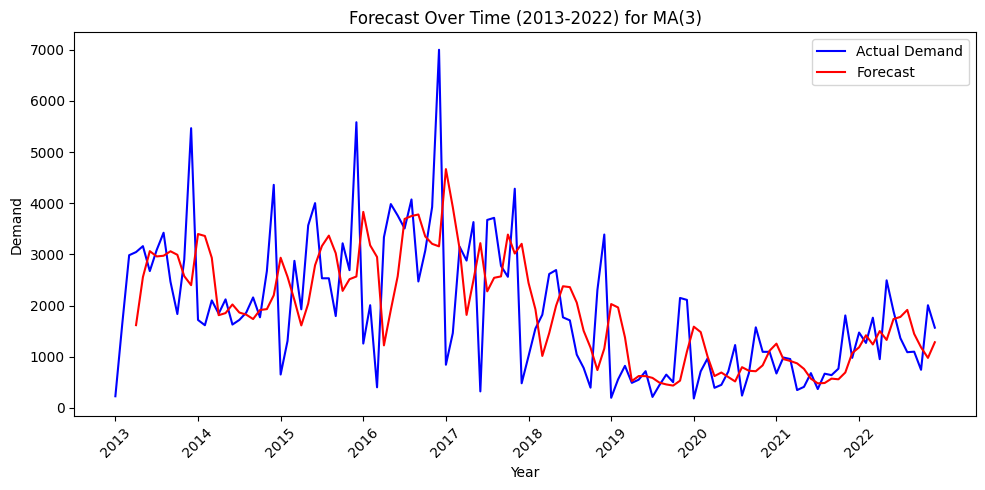

In [285]:
forecast = three_period_moving_avg_series(demand, get_start_time(2013))
plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Forecast Over Time (2013-2022) for MA(3)')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.plot(demand, color = "blue", label='Actual Demand')
plt.plot(forecast, color='red', label='Forecast')
plt.legend()

Error Metrics for 3-Period Moving Averages

In [286]:
mae = mean_absolute_error(demand, forecast, 2019, 2022)
mape = mean_abs_percentage_error(demand, forecast, 2019, 2022)
rmse = root_mean_squared_error(demand, forecast, 2019, 2022)
print("Three-Period Moving Average Forecast:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Three-Period Moving Average Forecast:
Mean Absolute Error (MAE): 460.8680555555555
Mean Absolute Percentage Error (MAPE): 82.30538388339788
Root Mean Squared Error (RMSE): 649.3309038427058


Prediction Intervals

In [287]:
def get_pred_interval(forecast, confidence_level, rmse):
    alpha = 1 - confidence_level
    z_value = norm.ppf(1 - alpha / 2)
    std = rmse
    offset = std * z_value
    return (forecast - offset, forecast + offset)

def get_pred_interval_list(forecast, confidence_level, rmse, start_year = 2022, question_num = 1):
    forecast = forecast[get_start_time(start_year, question_num) : get_end_time(start_year, question_num) + 1]
    return [get_pred_interval(i_forecast, confidence_level, rmse) for i_forecast in forecast]

print("90 percent prediction intervals for the one-month ahead forecasts using 3-month moving averages for year 2022:")
print(get_pred_interval_list(forecast, 0.9, root_mean_squared_error(demand, forecast, 2014, 2018)))

90 percent prediction intervals for the one-month ahead forecasts using 3-month moving averages for year 2022:
[(-1305.452062412552, 3673.452062412552), (-1070.1187290792188, 3908.7853957458856), (-1249.1187290792188, 3729.7853957458856), (-987.4520624125521, 3991.452062412552), (-1160.7853957458854, 3818.1187290792186), (-753.1187290792188, 4225.785395745886), (-710.7853957458854, 4268.118729079219), (-574.1187290792188, 4404.785395745886), (-1042.1187290792188, 3936.7853957458856), (-1305.7853957458854, 3673.1187290792186), (-1511.7853957458856, 3467.1187290792186), (-1205.7853957458854, 3773.1187290792186)]


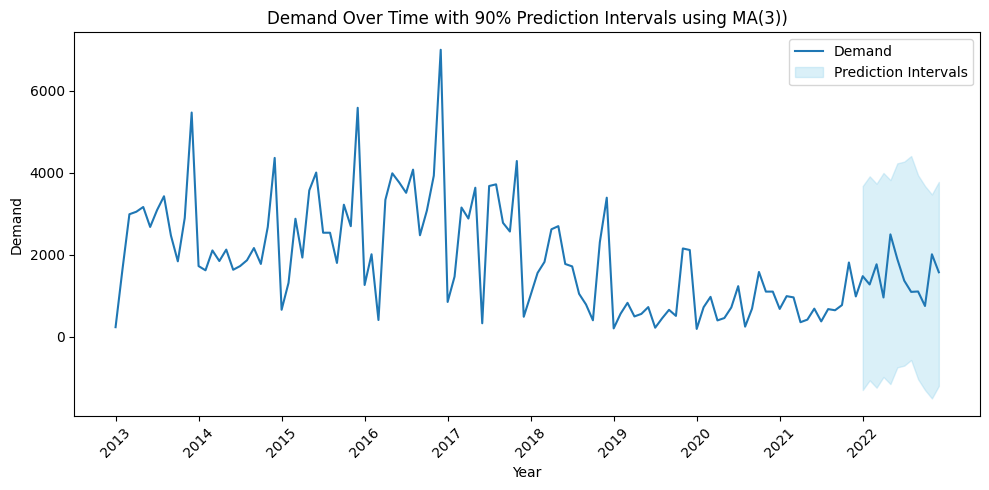

In [288]:
intervals = get_pred_interval_list(forecast, 0.9, root_mean_squared_error(demand, forecast, 2014, 2018))
lower_bound = [interval[0] for interval in intervals]
upper_bound = [interval[1] for interval in intervals]

plt.figure(figsize=(10, 5))
plt.plot(demand, label="Demand")
plt.fill_between(
    range(9 * 12, len(lower_bound) + 9 * 12),
    lower_bound,
    upper_bound,
    color="skyblue",
    alpha=0.3,
    label="Prediction Intervals",
)
plt.xticks(range(0, len(df["Year"]), 12), df["Year"].unique(), rotation=45)
plt.title(f"Demand Over Time with 90% Prediction Intervals using MA(3))")
plt.xlabel("Year")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()

# PART D

Residuals for MA(3) Forecast

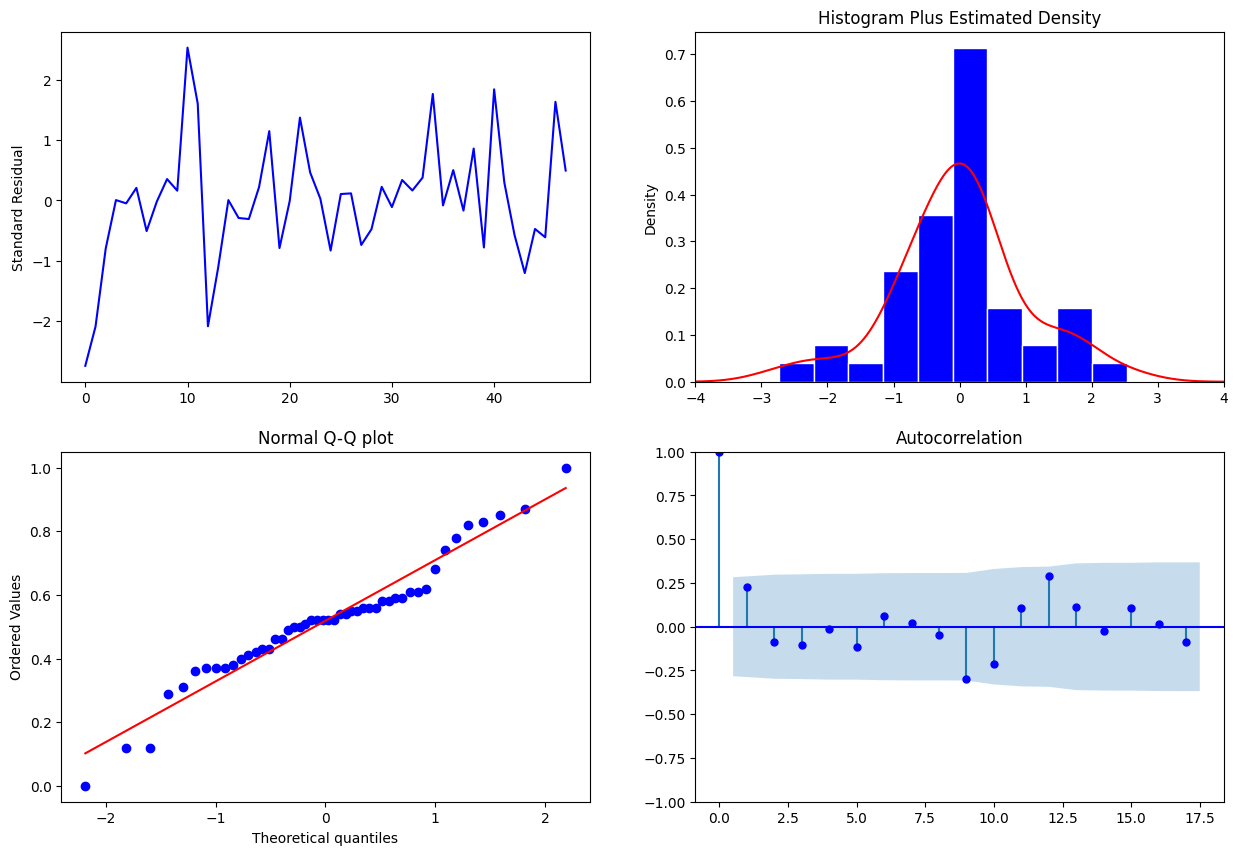

Fail to reject the null hypothesis. The mean of residuals could plausibly be zero.


In [289]:
residuals = get_residuals(demand, forecast, 2019, 2022)
bijan.eplot(residuals)
print(test_residual_mean(residuals))

# PART E

Simple Exponential Smoothing

In [290]:
def simple_exp_F_t(demand, t, alpha, start_year, memo={}):
    if get_start_time(start_year) > t:
        return None
    if get_start_time(start_year) == t:
        return np.nanmean(demand.loc[:t])

    if (tuple(demand), t, alpha, start_year) in memo:
        return memo[(tuple(demand), t, alpha, start_year)]

    result = alpha * demand.loc[t - 1] + (1 - alpha) * simple_exp_F_t(demand, t - 1, alpha, start_year, memo)
    memo[(tuple(demand), t, alpha, start_year)] = result
    return result

def get_simple_exp_series(demand, alpha, start_year):
    return [simple_exp_F_t(demand, t, alpha, start_year) for t in range(len(demand))]

Graphs for different smoothing constants (alpha = 0.1, 0.2, ..., 1)

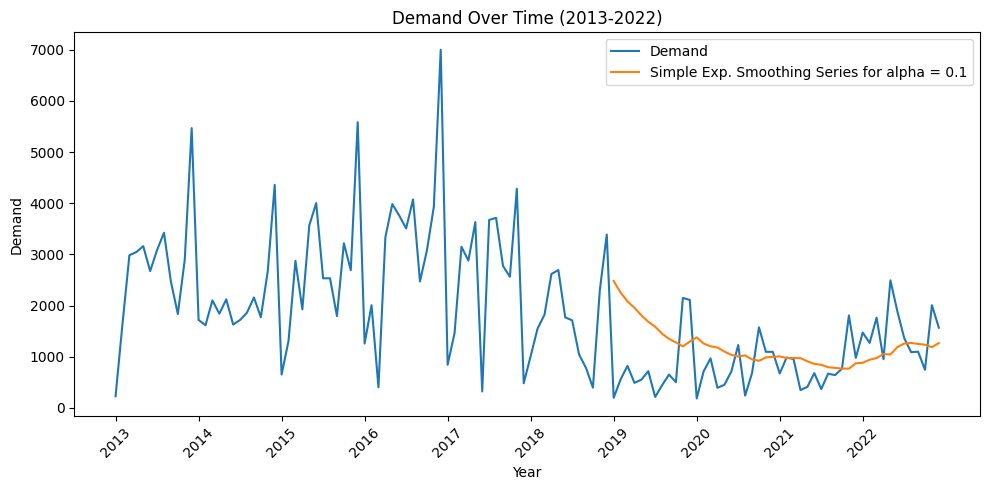

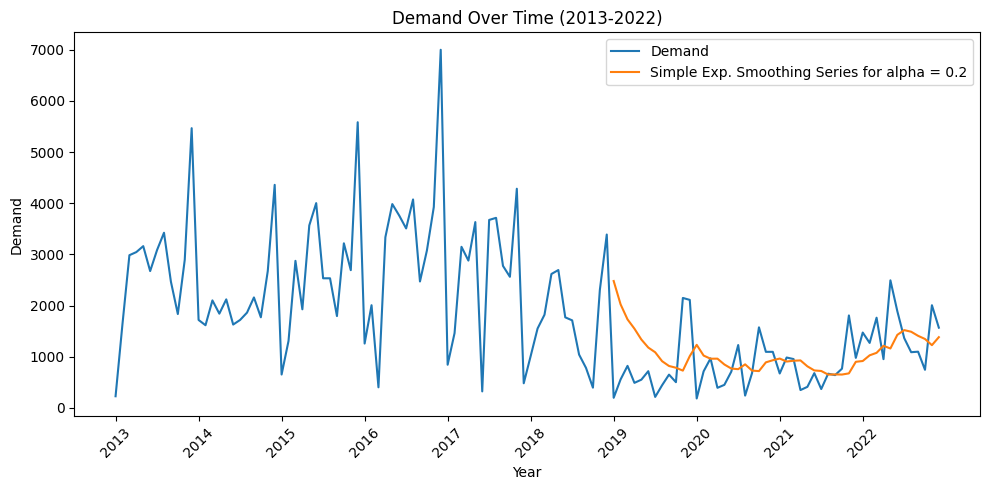

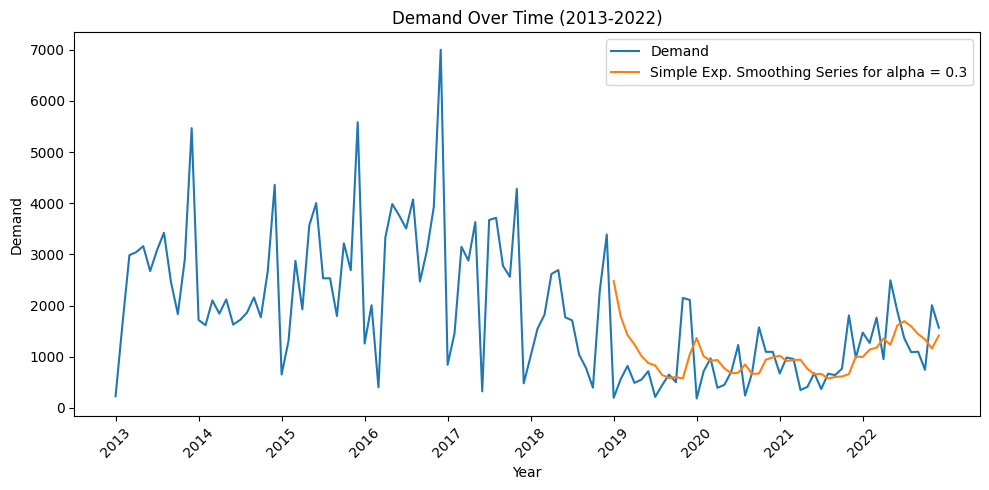

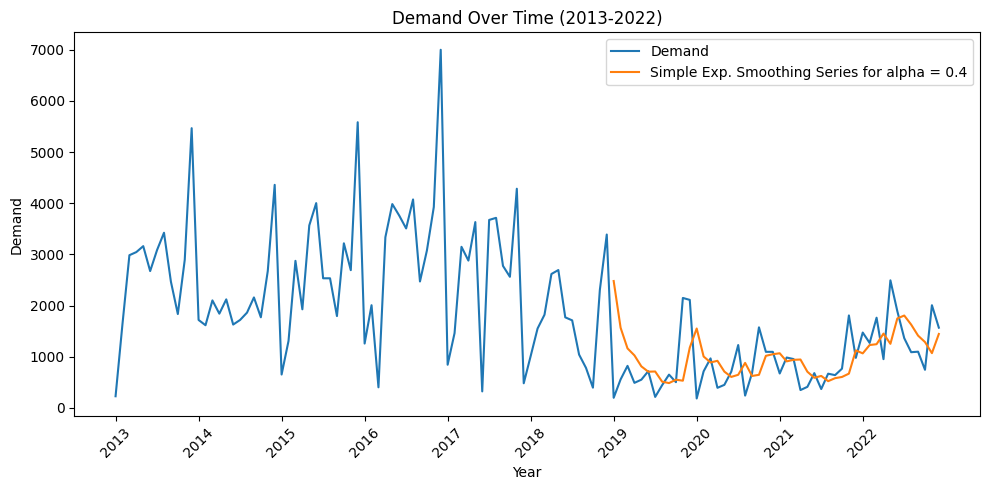

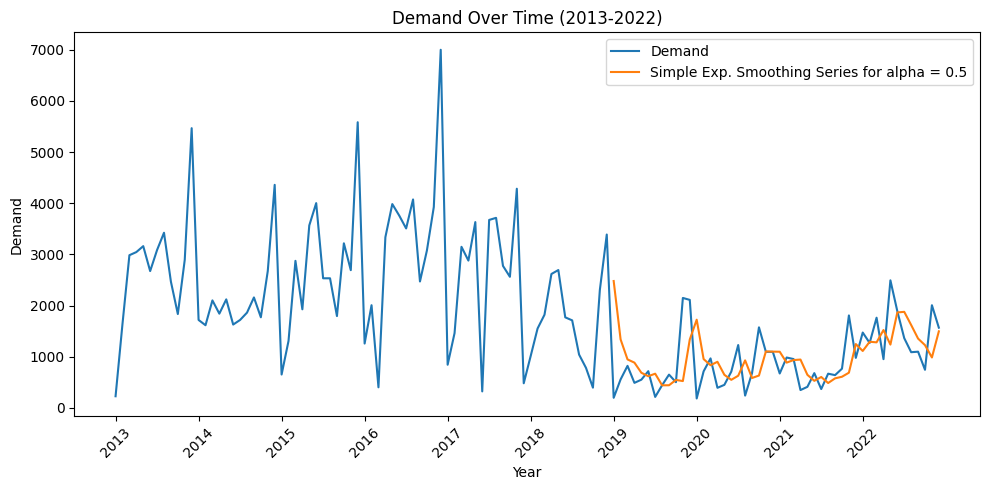

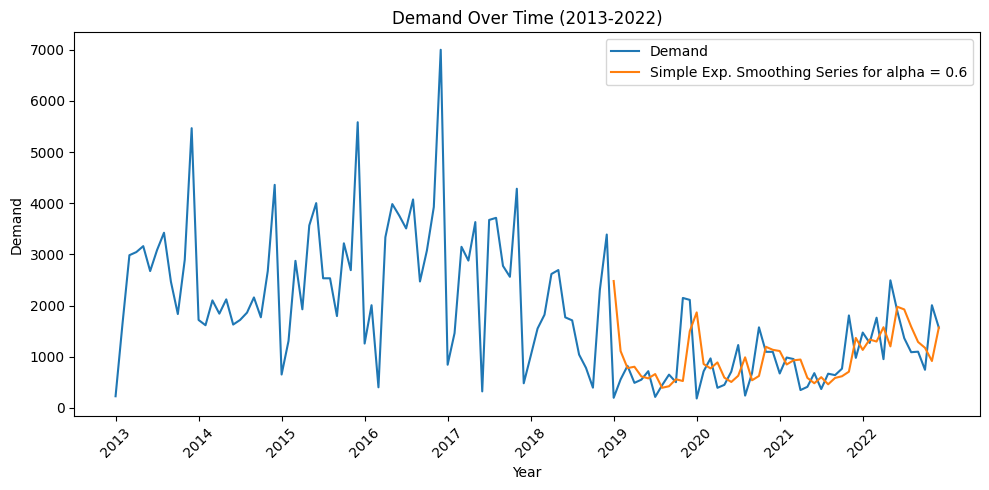

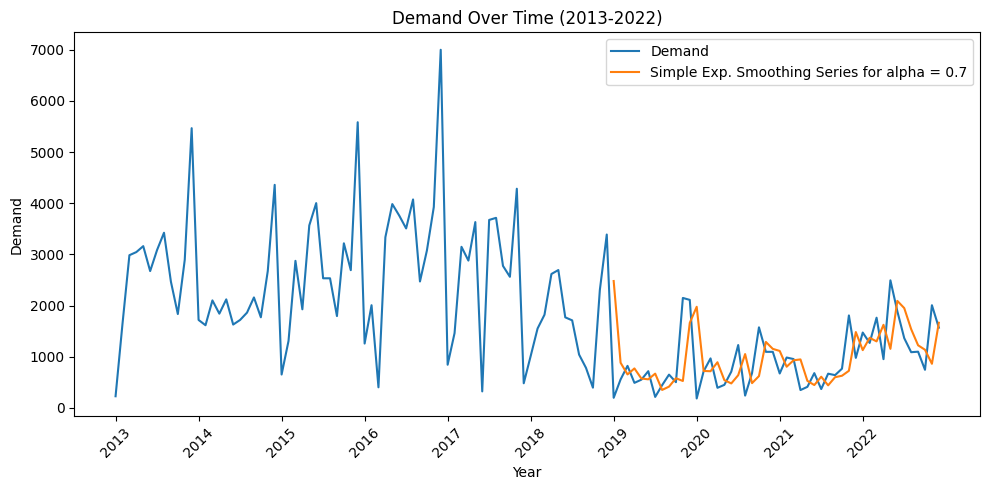

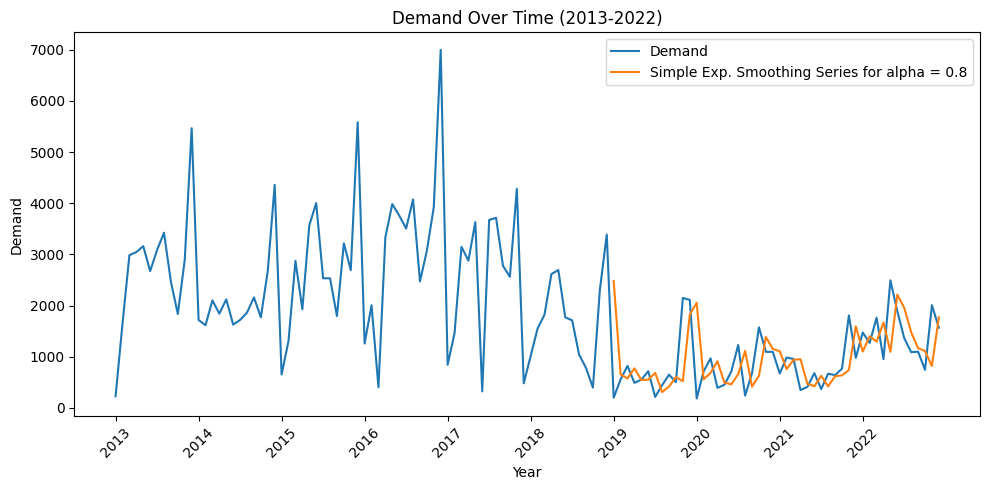

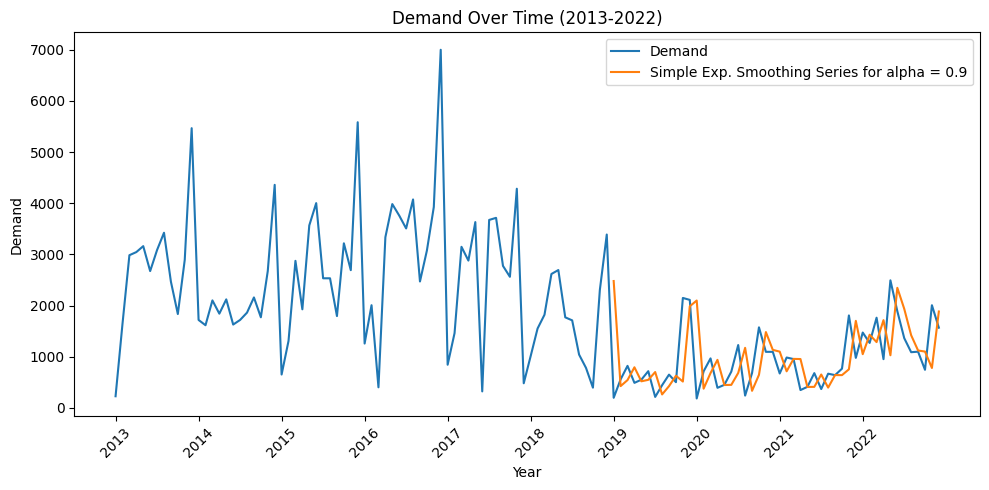

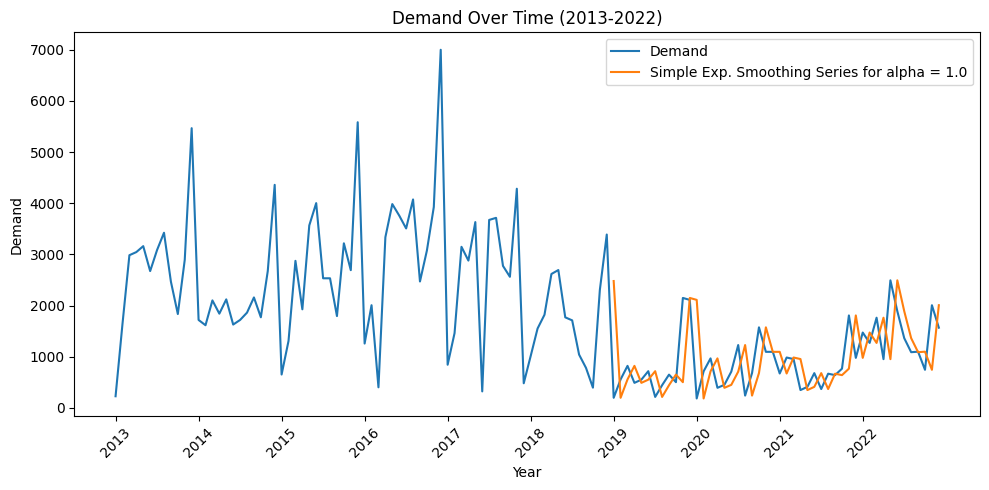

In [291]:
for alpha in range(1,11):
    alpha /= 10
    
    simple_exp_series = get_simple_exp_series(demand, alpha, 2019)
    
    plt.figure(figsize=(10, 5))
    plt.plot(demand, label='Demand')
    plt.plot(range(len(simple_exp_series)), simple_exp_series, label=f'Simple Exp. Smoothing Series for alpha = {alpha}')
    plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
    plt.title('Demand Over Time (2013-2022)')
    plt.xlabel('Year')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plt.show()

Error Metrics for Different Smoothing Constants ($\alpha$ = 0.1, 0.2, ..., 1)

In [292]:
rmse_values = []
mape_values = []
mae_values = []

for i, alpha in enumerate(range(1, 11)):
    alpha /= 10
    simple_exp_series = get_simple_exp_series(demand, alpha, 2019)
    
    rmse = root_mean_squared_error(df['Demand'], simple_exp_series, 2019, 2022)
    mape = mean_abs_percentage_error(df['Demand'], simple_exp_series, 2019, 2022)
    mae = mean_absolute_error(df['Demand'], simple_exp_series, 2019, 2022)
    
    rmse_values.append(rmse)
    mape_values.append(mape)
    mae_values.append(mae)

min_rmse_alpha = (rmse_values.index(min(rmse_values)) + 1) / 10
min_mape_alpha = (mape_values.index(min(mape_values)) + 1) / 10
min_mae_alpha = (mae_values.index(min(mae_values)) + 1) / 10

min_rmse = min(rmse_values)
min_mape = min(mape_values)
min_mae = min(mae_values)

print("Alpha value corresponding to minimum error metrics:")
print("Minimum RMSE:", min_rmse, "- Alpha:", min_rmse_alpha)
print("Minimum MAPE:", min_mape, "- Alpha:", min_mape_alpha)
print("Minimum MAE:", min_mae, "- Alpha:", min_mae_alpha)



Alpha value corresponding to minimum error metrics:
Minimum RMSE: 649.0755572727516 - Alpha: 0.5
Minimum MAPE: 87.6341205402615 - Alpha: 0.5
Minimum MAE: 441.27351947818926 - Alpha: 0.5


Optimal Alpha Value = 0.5

Prediction Intervals for Simple Exponential Smoothing

In [293]:
optimal_alpha = 0.5
rmse_forecast = get_simple_exp_series(demand, optimal_alpha, 2014)
forecast = get_simple_exp_series(demand, optimal_alpha, 2019)
print("90 percent prediction intervals for the one-month ahead forecasts using simple exp. smoothing for year 2022:")
print(get_pred_interval_list(forecast, 0.9, root_mean_squared_error(demand, rmse_forecast, 2014, 2018)))

90 percent prediction intervals for the one-month ahead forecasts using simple exp. smoothing for year 2022:
[(-1247.2652184939614, 3472.8828946325975), (-1067.1696375286206, 3652.9784755979385), (-1078.62184704595, 3641.5262660806093), (-837.8479518046147, 3882.3001613219444), (-1122.4610041839471, 3597.687108942612), (-494.7675303736132, 4225.380582752946), (-482.4207934684464, 4237.727319658113), (-739.747425015863, 3980.400688110696), (-1005.4107407895713, 3714.737372336988), (-1133.2423986764254, 3586.905714450134), (-1374.1582276198524, 3345.9898855067067), (-863.616142091566, 3856.531971034993)]


%90 Prediction Interval Graph for alpha = 0.5

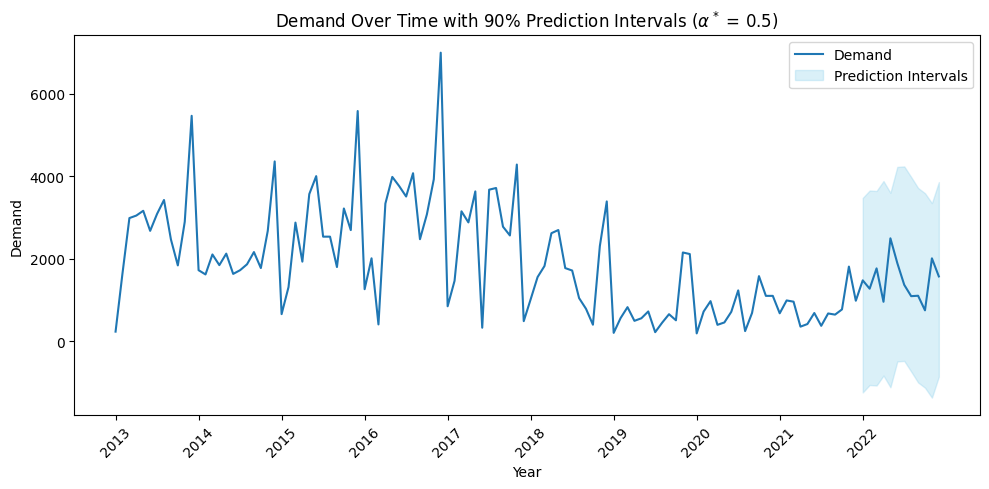

In [294]:
rmse_forecast = get_simple_exp_series(demand, optimal_alpha, 2014)
forecast = get_simple_exp_series(demand, optimal_alpha, 2019)
intervals = get_pred_interval_list(forecast, 0.9, root_mean_squared_error(demand, rmse_forecast, 2014, 2018))
lower_bound = [interval[0] for interval in intervals]
upper_bound = [interval[1] for interval in intervals]

plt.figure(figsize=(10, 5))
plt.plot(demand, label='Demand')
plt.fill_between(range(9 * 12, len(lower_bound) + 9 * 12 ), lower_bound, upper_bound, color='skyblue', alpha=0.3, label='Prediction Intervals')
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Demand Over Time with 90% Prediction Intervals ($\\alpha^*$ = {optimal_alpha})')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()


Comparing Simple Exponential Smoothing Results with MA-3 Forecasts on the Actual Demand Graph

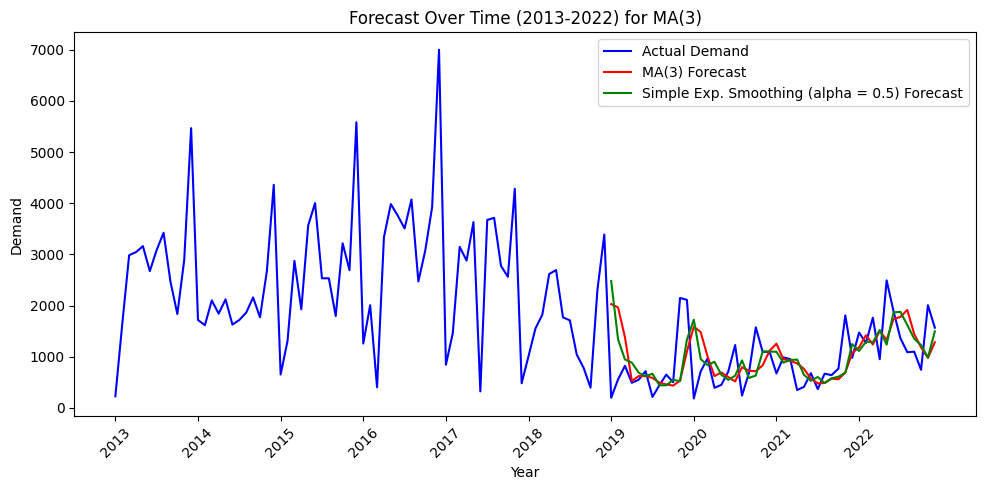

In [295]:
moving_average = three_period_moving_avg_series(demand, get_start_time(2019))
simple_exp = get_simple_exp_series(demand, 0.5, 2019)
plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Forecast Over Time (2013-2022) for MA(3)')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.plot(demand, color = "blue", label='Actual Demand')
plt.plot(moving_average, color='red', label='MA(3) Forecast')
plt.plot(simple_exp, color='green', label='Simple Exp. Smoothing (alpha = 0.5) Forecast')
plt.legend()

Error Metric Comparisons: Simple Exponential Smoothing vs. MA(3)

In [296]:
rmse_simple_exp = min(rmse_values)
mae_simple_exp = min(mae_values)
mape_simple_exp = min(mape_values)

rmse_moving_av = root_mean_squared_error(demand, moving_average, 2019, 2022)
mae_moving_av = mean_absolute_error(demand, moving_average, 2019, 2022)
mape_moving_av = mean_abs_percentage_error(demand, moving_average, 2019, 2022)

print("Comparison of Forecasting Methods (2019 - 2022):\n")

print("Exponential Smoothing Results:")
print(f"- RMSE: {rmse_simple_exp:.4f}")
print(f"- MAE: {mae_simple_exp:.4f}")
print(f"- MAPE: {mape_simple_exp:.4f}%\n")

print("Moving Averages Results:")
print(f"- RMSE: {rmse_moving_av:.4f}")
print(f"- MAE: {mae_moving_av:.4f}")
print(f"- MAPE: {mape_moving_av:.4f}%\n")

print("Comparison Summary:")
winner = ("Exponential Smoothing" if rmse_simple_exp < rmse_moving_av else "Moving Averages")
print(f"- {winner} provides a lower RMSE, indicating better performance in minimizing the square root of the average of squared differences between predicted and actual values.")

winner = ("Exponential Smoothing" if mae_simple_exp < mae_moving_av else "Moving Averages")
print(f"- {winner} provides a lower MAE, indicating better performance in minimizing the average magnitude of the errors in a set of predictions, without considering their direction.")

winner = ("Exponential Smoothing" if mape_simple_exp < mape_moving_av else "Moving Averages")
print(f"- {winner} provides a lower MAPE, indicating better performance in minimizing the average of the absolute percentage errors, making it a measure of accuracy in a fitted time series.")

Comparison of Forecasting Methods (2019 - 2022):

Exponential Smoothing Results:
- RMSE: 649.0756
- MAE: 441.2735
- MAPE: 87.6341%

Moving Averages Results:
- RMSE: 649.3309
- MAE: 460.8681
- MAPE: 82.3054%

Comparison Summary:
- Exponential Smoothing provides a lower RMSE, indicating better performance in minimizing the square root of the average of squared differences between predicted and actual values.
- Exponential Smoothing provides a lower MAE, indicating better performance in minimizing the average magnitude of the errors in a set of predictions, without considering their direction.
- Moving Averages provides a lower MAPE, indicating better performance in minimizing the average of the absolute percentage errors, making it a measure of accuracy in a fitted time series.


# PART F

Double Exponential Smoothing

In [297]:
def double_exp_forecast_iterative(demand, alpha, beta, start_time, S0, G0, k=1):
    # Initialize intercept and slope with initial values
    St = S0
    Gt = G0
    forecast_list = []
    for i in range(k):
        forecast_list.append(None)
    for t in range(len(demand)):
        if t < start_time - k + 1:
            forecast_list.append(None)
            continue
        # Update intercept and slope using exponential smoothing
        St_1 = alpha * demand.loc[t - 1] + (1 - alpha) * (St + Gt)
        Gt_1 = beta * (St_1 - St) + (1 - beta) * Gt

        # Forecast for the next period
        forecast = St_1 + k * Gt_1
        forecast_list.append(forecast)

        # Update St and Gt for the next iteration
        St = St_1
        Gt = Gt_1

    return forecast_list


In [298]:
def initialize_double_exp_model(demand, start_time, k = 1):
    relevant_demand = demand.loc[:start_time + k - 1]
    # Calculate initial slope using linear regression with statsmodels
    X = np.array(range(len(relevant_demand)))
    X = sm.add_constant(X) 
    y = relevant_demand
    model = sm.OLS(y, X)
    results = model.fit()
    slope = results.params[1]  
    level = results.params[0]  
    return level, slope

Initialization of Double Exponential Smoothing Model and Forecast Calculation to find the best smoothing constants (alpha* and beta*)

In [299]:
start_time = get_start_time(2019)
reg_level, reg_slope = initialize_double_exp_model(demand, start_time)
best_mape = float('inf')
best_mae = float('inf')
best_rmse = float('inf')
best_alpha_mape = None
best_beta_mape = None
best_alpha_mae = None
best_beta_mae = None
best_alpha_rmse = None
best_beta_rmse = None

for alpha in np.arange(0.1, 1.1, 0.1):
    for beta in np.arange(0.1, 1.1, 0.1):
        forecast = double_exp_forecast_iterative(demand, alpha, beta, start_time, reg_level, reg_slope)

        mape = mean_abs_percentage_error(demand, forecast, 2019, 2022)
        mae = mean_absolute_error(demand, forecast, 2019, 2022)
        rmse = root_mean_squared_error(demand, forecast, 2019, 2022)
   
        if mape < best_mape:
            best_mape = mape
            best_alpha_mape = round(alpha, 1)
            best_beta_mape = round(beta, 1)
        if mae < best_mae:
            best_mae = mae
            best_alpha_mae = round(alpha, 1)
            best_beta_mae = round(beta, 1)
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha_rmse = round(alpha, 1)
            best_beta_rmse = round(beta, 1)

print("Best MAPE:", best_mape)
print("Corresponding Alpha (MAPE):", best_alpha_mape)
print("Corresponding Beta (MAPE):", best_beta_mape)

print("Best MAE:", best_mae)
print("Corresponding Alpha (MAE):", best_alpha_mae)
print("Corresponding Beta (MAE):", best_beta_mae)

print("Best RMSE:", best_rmse)
print("Corresponding Alpha (RMSE):", best_alpha_rmse)
print("Corresponding Beta (RMSE):", best_beta_rmse)



Best MAPE: 69.80290423154662
Corresponding Alpha (MAPE): 0.3
Corresponding Beta (MAPE): 0.1
Best MAE: 541.8243398590141
Corresponding Alpha (MAE): 0.5
Corresponding Beta (MAE): 0.1
Best RMSE: 740.3038392206994
Corresponding Alpha (RMSE): 0.4
Corresponding Beta (RMSE): 0.1


Graph for the Double Exponential Smoothing Model with optimal smoothing constants

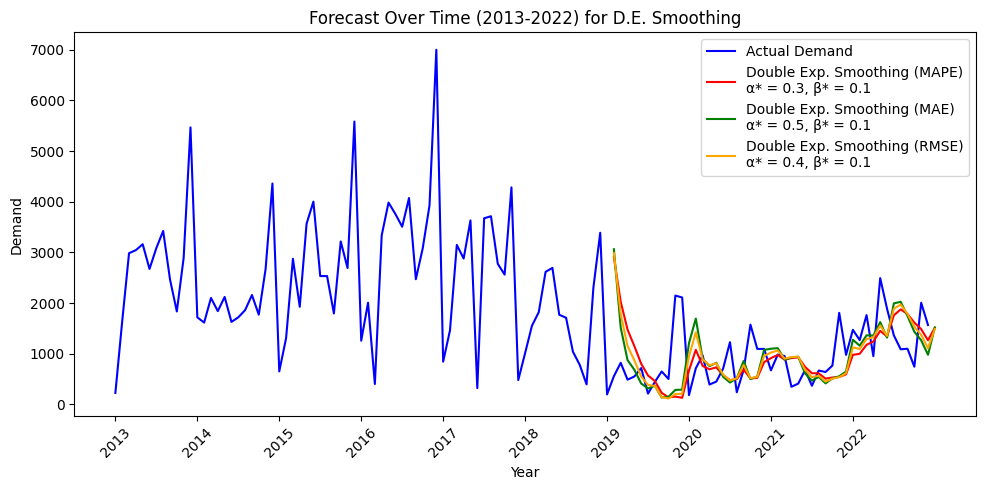

In [300]:
optimal_double_exp_mape = double_exp_forecast_iterative(demand, best_alpha_mape, best_beta_mape, start_time, reg_level, reg_slope)
optimal_double_exp_mae = double_exp_forecast_iterative(demand, best_alpha_mae, best_beta_mae, start_time, reg_level, reg_slope)
optimal_double_exp_rmse = double_exp_forecast_iterative(demand, best_alpha_rmse, best_beta_rmse, start_time, reg_level, reg_slope)

plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Forecast Over Time (2013-2022) for D.E. Smoothing')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()

# Plot actual demand
plt.plot(demand, color="blue", label='Actual Demand')

# Plot forecasts for different error metrics with different colors
plt.plot(optimal_double_exp_mape, color='red', label=f'Double Exp. Smoothing (MAPE)\nα* = {best_alpha_mape}, β* = {best_beta_mape}')
plt.plot(optimal_double_exp_mae, color='green', label=f'Double Exp. Smoothing (MAE)\nα* = {best_alpha_mae}, β* = {best_beta_mae}')
plt.plot(optimal_double_exp_rmse, color='orange', label=f'Double Exp. Smoothing (RMSE)\nα* = {best_alpha_rmse}, β* = {best_beta_rmse}')

plt.legend()
plt.show()


Prediction Intervals

%90 Prediction Interval Graph for Double Exponential Smoothing

90 percent prediction intervals for the one-month ahead forecasts using double exponential smoothing (alpha = 0.4, beta = 0.1):
(-1359.3815388805535, 3612.605627328696)
(-1390.9495415524175, 3581.0376246568317)
(-1196.7721048176243, 3775.2150613916247)
(-1162.2345019082284, 3809.7526643010206)
(-926.7423034104468, 4045.2448627988024)
(-1133.6970354995449, 3838.2901307097045)
(-596.2417366572067, 4375.745429552042)
(-514.9586312097006, 4457.028534999548)
(-701.3101660169941, 4270.677000192255)
(-950.5484235848751, 4021.438742624374)
(-1113.5491845063939, 3858.4379817028553)
(-1378.0474170032342, 3593.939749206015)


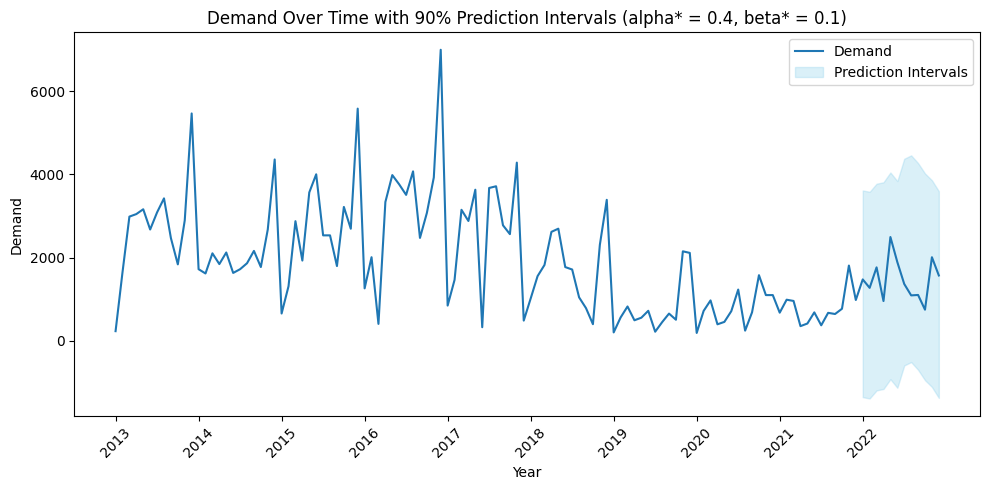

In [301]:
optimal_double_exp = optimal_double_exp_rmse
alpha_star = best_alpha_rmse
beta_star = best_beta_rmse
std_estimator = root_mean_squared_error(demand, double_exp_forecast_iterative(demand, alpha_star, beta_star, get_start_time(2014), reg_level, reg_slope), 2014, 2018)
intervals = get_pred_interval_list(optimal_double_exp, 0.9, std_estimator)

lower_bound = [interval[0] for interval in intervals]
upper_bound = [interval[1] for interval in intervals]
print(f"90 percent prediction intervals for the one-month ahead forecasts using double exponential smoothing (alpha = {alpha_star}, beta = {beta_star}):")
for interval in intervals:
    print(interval)
plt.figure(figsize=(10, 5))
plt.plot(demand, label='Demand')
plt.fill_between(range(9 * 12, len(lower_bound) + 9 * 12 ), lower_bound, upper_bound, color='skyblue', alpha=0.3, label='Prediction Intervals')
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Demand Over Time with 90% Prediction Intervals (alpha* = {alpha_star}, beta* = {beta_star})')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.tight_layout()
plt.show()

# PART G

Residuals

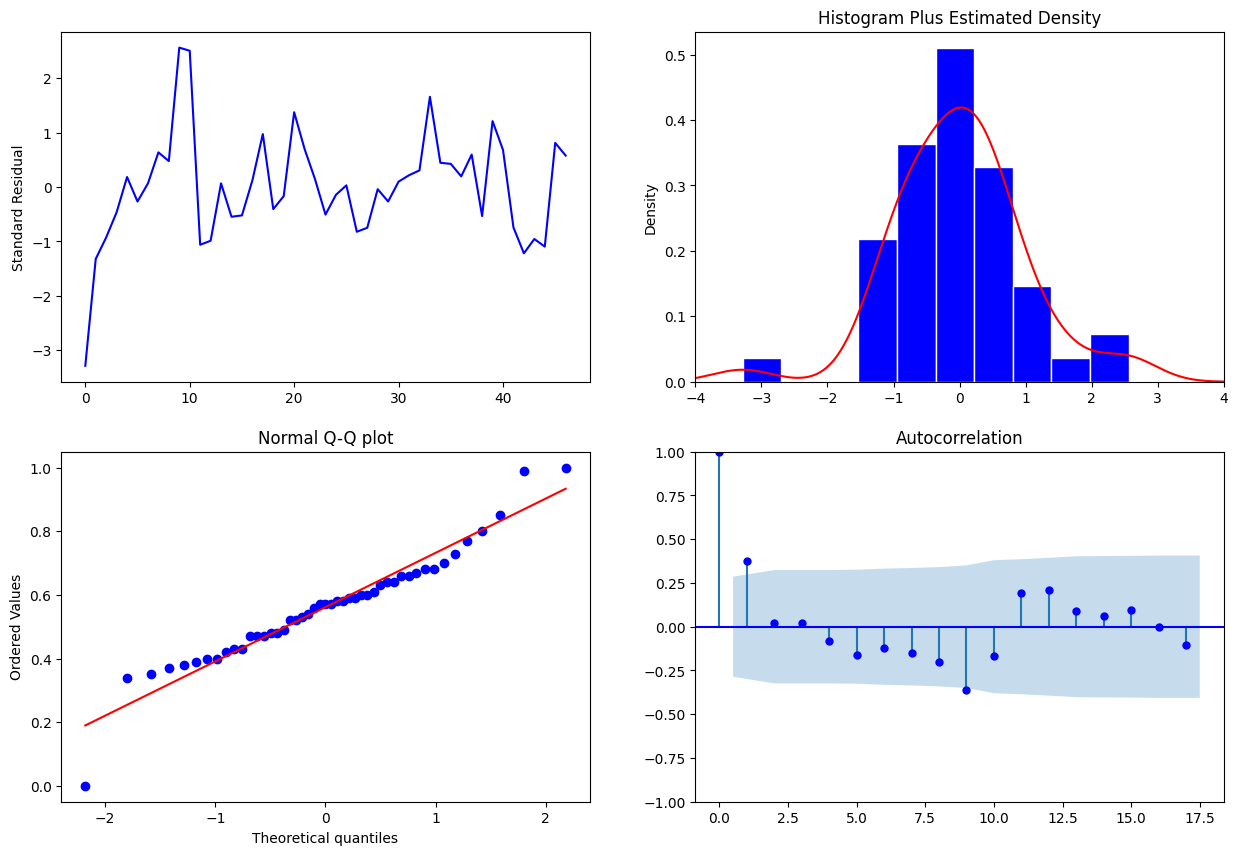

Fail to reject the null hypothesis. The mean of residuals could plausibly be zero.


In [302]:
residuals = get_residuals(demand, optimal_double_exp, 2019, 2022)
bijan.eplot(residuals)
print(test_residual_mean(residuals))

# PART H

3-month and 6-month ahead forecasts for year 2022

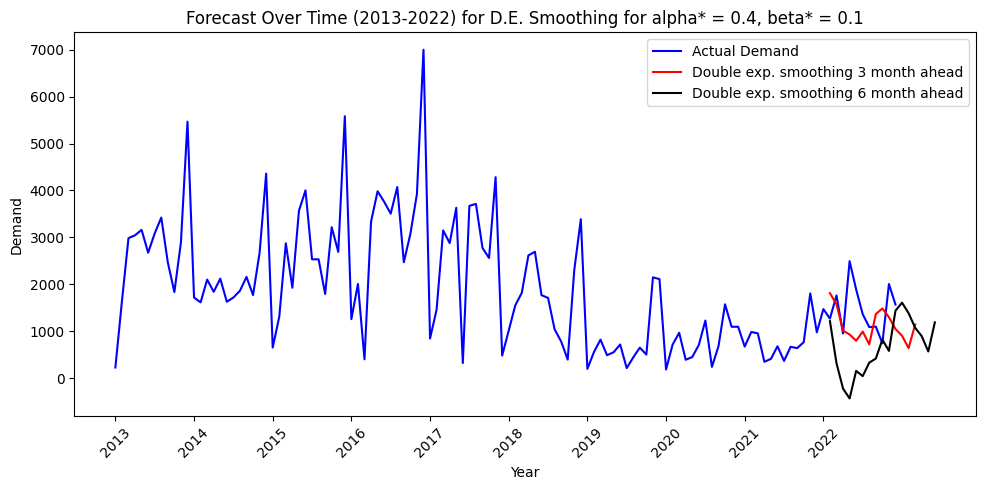

In [303]:
start_time = get_start_time(2022)
reg_level, reg_slope = initialize_double_exp_model(demand, start_time)
three_month_ahead_forecast = double_exp_forecast_iterative(demand, alpha_star, beta_star, start_time, reg_level, reg_slope, 3)
six_month_ahead_forecast = double_exp_forecast_iterative(demand, alpha_star, beta_star, start_time, reg_level, reg_slope, 6)

plt.figure(figsize=(10, 5))
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Forecast Over Time (2013-2022) for D.E. Smoothing for alpha* = {alpha_star}, beta* = {beta_star}')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.plot(demand, color="blue", label='Actual Demand')
plt.plot(three_month_ahead_forecast, color='red', label='Double exp. smoothing 3 month ahead')
plt.plot(six_month_ahead_forecast, color='black', label='Double exp. smoothing 6 month ahead')
plt.legend()
plt.show()

Re-calculating alpha* and beta* values for 3-month ahead and 6-month ahead forecasts for 2022

In [304]:
for k in (3, 6):
    forecast = double_exp_forecast_iterative(demand, alpha_star, beta_star, get_start_time(2019), reg_level, reg_slope, k)
    mape = mean_abs_percentage_error(demand, forecast, 2019, 2022)
    mae = mean_absolute_error(demand, forecast, 2019, 2022)
    rmse = root_mean_squared_error(demand, forecast, 2019, 2022)
    
    print(f"For {k} lookahead")
    print("MAPE:", mape)
    print("MAE:", mae)
    print("RMSE:", rmse)

    alpha_star = best_alpha_mape
    beta_star = best_beta_mape

For 3 lookahead
MAPE: 78.63348054642816
MAE: 614.6487217994933
RMSE: 827.7481341972621
For 6 lookahead
MAPE: 93.56796998976698
MAE: 710.7496706175447
RMSE: 909.5499629820614


# PART I

Creating U_t Series to eliminate the effect of seasonality

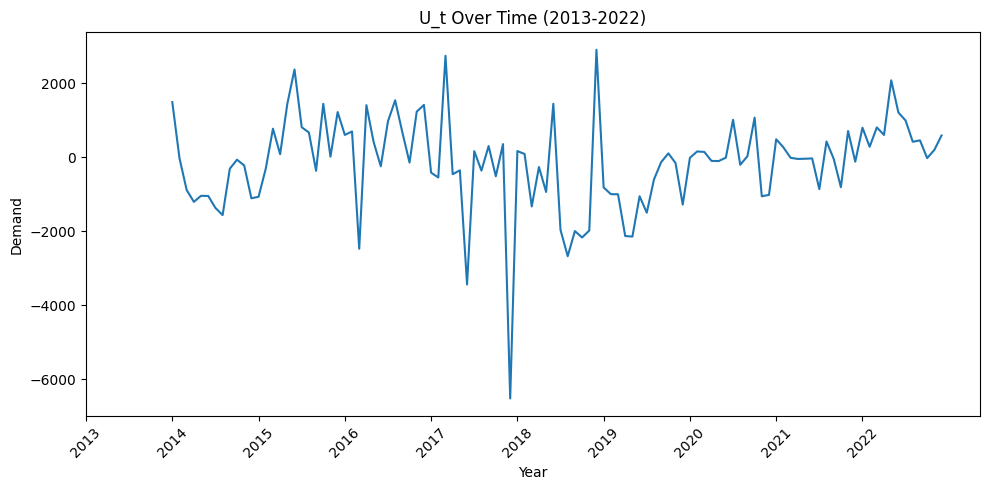

In [305]:
def transform_D_to_U(demand):
    out = []
    for t in range(len(demand)):
        if t < 12:
            out.append(None)
        else:
            out.append(demand.loc[t] - demand.loc[t - 12])
    return pd.DataFrame(out).loc[:,0]

U_series = transform_D_to_U(demand)

plt.figure(figsize=(10, 5))
plt.plot(U_series)
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title('U_t Over Time (2013-2022)')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()
        

In [306]:
rmse_values = []
mape_values = []
mae_values = []
for i, alpha in enumerate(range(1, 11)):
    alpha /= 10
    simple_exp_series = get_simple_exp_series(U_series, alpha, 2019)

    rmse = root_mean_squared_error(U_series, simple_exp_series, 2019, 2022)
    mape = mean_abs_percentage_error(U_series, simple_exp_series, 2019, 2022)
    mae = mean_absolute_error(U_series, simple_exp_series, 2019, 2022)

    rmse_values.append(rmse)
    mape_values.append(mape)
    mae_values.append(mae)

min_rmse_alpha = (rmse_values.index(min(rmse_values)) + 1) / 10
min_mape_alpha = (mape_values.index(min(mape_values)) + 1) / 10
min_mae_alpha = (mae_values.index(min(mae_values)) + 1) / 10

min_rmse = min(rmse_values)
min_mape = min(mape_values)
min_mae = min(mae_values)

print("Alpha value corresponding to minimum error metrics:")
print("Minimum RMSE:", min_rmse, "- Alpha:", min_rmse_alpha)
print("Minimum MAPE:", min_mape, "- Alpha:", min_mape_alpha)
print("Minimum MAE:", min_mae, "- Alpha:", min_mae_alpha)
alpha_star = min_mae_alpha

Alpha value corresponding to minimum error metrics:
Minimum RMSE: 678.6200392461592 - Alpha: 0.4
Minimum MAPE: 326.50998844042635 - Alpha: 0.4
Minimum MAE: 534.6402760463778 - Alpha: 0.4


G_t: Simple Exponential Smoothing Series using U_t

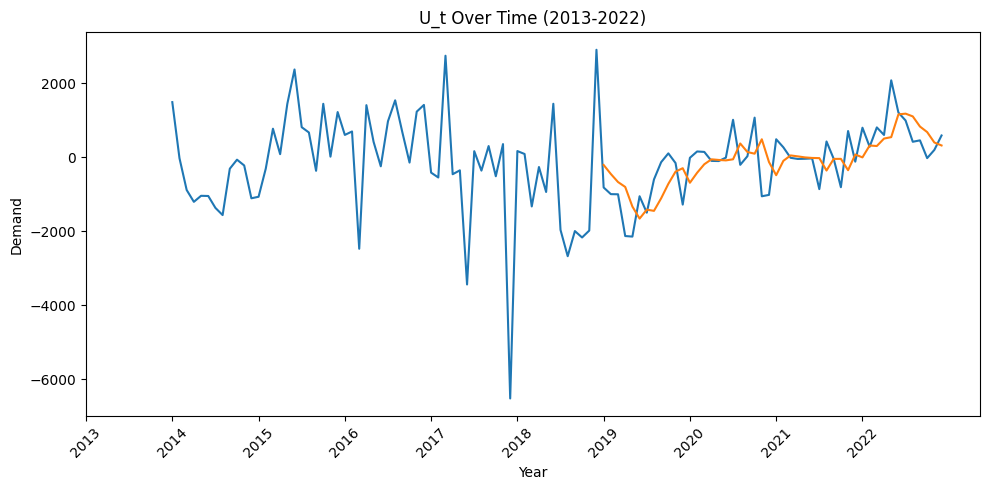

In [307]:
G_t_series_star = pd.DataFrame(get_simple_exp_series(U_series, alpha_star, 2019))
plt.figure(figsize=(10, 5))
plt.plot(U_series)
plt.plot(G_t_series_star)
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title('U_t Over Time (2013-2022)')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

In [308]:
def get_G_t(G_t_series, t):
    return G_t_series.iloc[t, 0]

def get_F_t(demand, G_t_series, t, gamma, start_time):
    if t < start_time - 12:
        return None
    if t <= start_time:
        initial_demand = np.nanmean(demand.iloc[:t])
        return initial_demand
    return (get_G_t(G_t_series, t) + gamma * (demand.iloc[t - 12]) + (1 - gamma) * get_F_t(demand, G_t_series, t - 12, gamma, start_time))

In [309]:
mape_values = []
rmse_values = []
mae_values = []
start_time = get_start_time(2019)

for gamma in np.arange(0, 1.1, 0.1):
    F_series = [get_F_t(demand, G_t_series_star, t, gamma, start_time) for t in range(len(demand))]
    for t in range(start_time - 12, start_time):
        F_series[t] = None
    mape = mean_abs_percentage_error(demand, F_series, 2019, 2022)
    rmse = root_mean_squared_error(demand, F_series, 2019, 2022)
    mae = mean_absolute_error(demand, F_series, 2019, 2022)

    mape_values.append(mape)
    rmse_values.append(rmse)
    mae_values.append(mae)

min_mape_gamma = mape_values.index(min(mape_values)) / 10
min_rmse_gamma = rmse_values.index(min(rmse_values)) / 10
min_mae_gamma = mae_values.index(min(mae_values)) / 10

print("Gamma value corresponding to minimum MAPE:", min_mape_gamma)
print("Gamma value corresponding to minimum RMSE:", min_rmse_gamma)
print("Gamma value corresponding to minimum MAE:", min_mae_gamma)

best_gamma = min(min_mape_gamma, min_rmse_gamma, min_mae_gamma)
F_series_best = [get_F_t(demand, G_t_series_star, t, best_gamma, start_time) for t in range(len(demand))]
for t in range(start_time - 12, start_time):
    F_series_best[t] = None

Gamma value corresponding to minimum MAPE: 0.7
Gamma value corresponding to minimum RMSE: 0.5
Gamma value corresponding to minimum MAE: 0.6


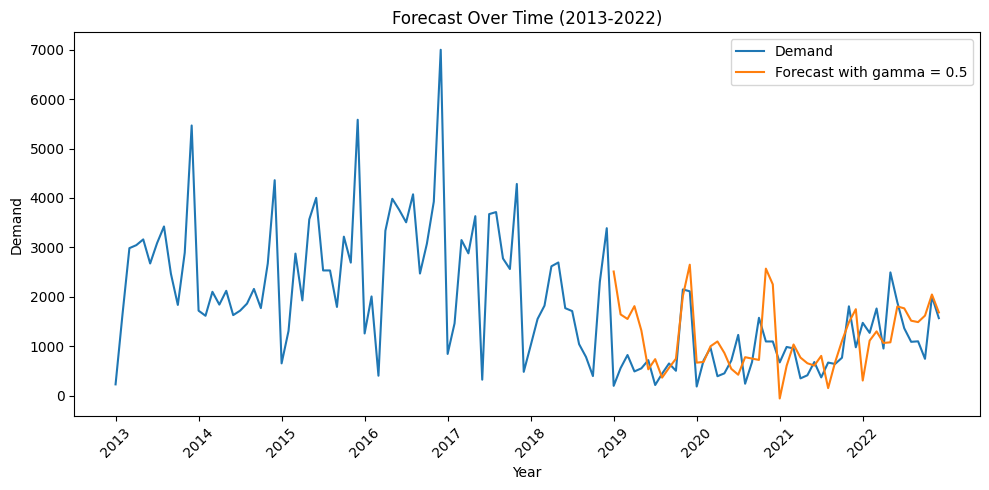

In [310]:
plt.figure(figsize=(10, 5))
plt.plot(demand, label="Demand")
plt.plot(F_series_best, label=f"Forecast with gamma = {best_gamma}")
plt.xticks(range(0, len(df["Year"]), 12), df["Year"].unique(), rotation=45)
plt.title("Forecast Over Time (2013-2022)")
plt.xlabel("Year")
plt.ylabel("Demand")
plt.legend()
plt.tight_layout()
plt.show()

# QUESTION 2: Forecasting Sales for Domestic Beer

# PART A

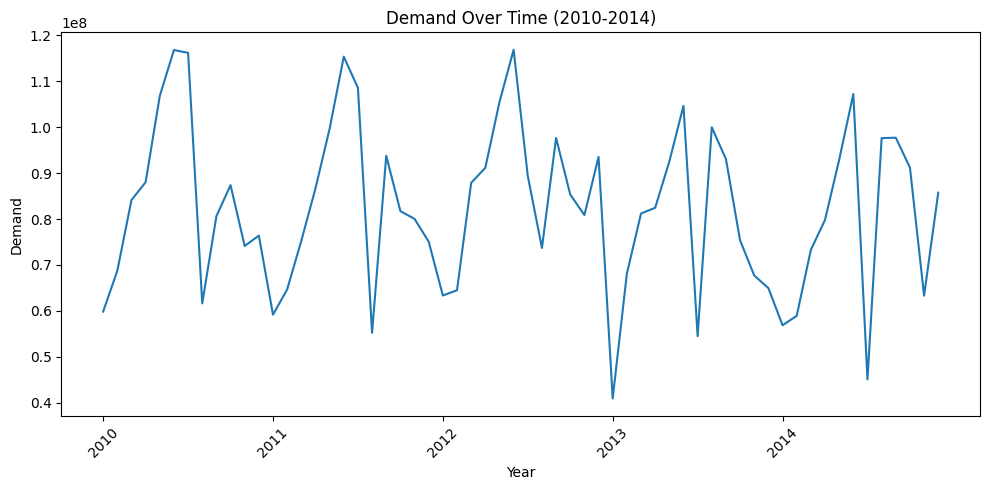

In [311]:
temp_df = pd.read_csv("domestic_beer_sales.csv", header=None)

df = pd.DataFrame()
df["Demand"] = temp_df.iloc[:, 1]  

dates = pd.date_range(start="2010-01-01", end="2014-12-31", freq="M")
df["Date"] = dates
df["Year"] = df["Date"].dt.year  
demand = df["Demand"]
plt.figure(figsize=(10, 5))
plt.plot(demand)  
plt.xticks(range(0, len(df["Year"]), 12), df["Year"].unique(), rotation=45)
plt.title("Demand Over Time (2010-2014)")
plt.xlabel("Year")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()

# PART B

Naive Forecast for Tau = 1

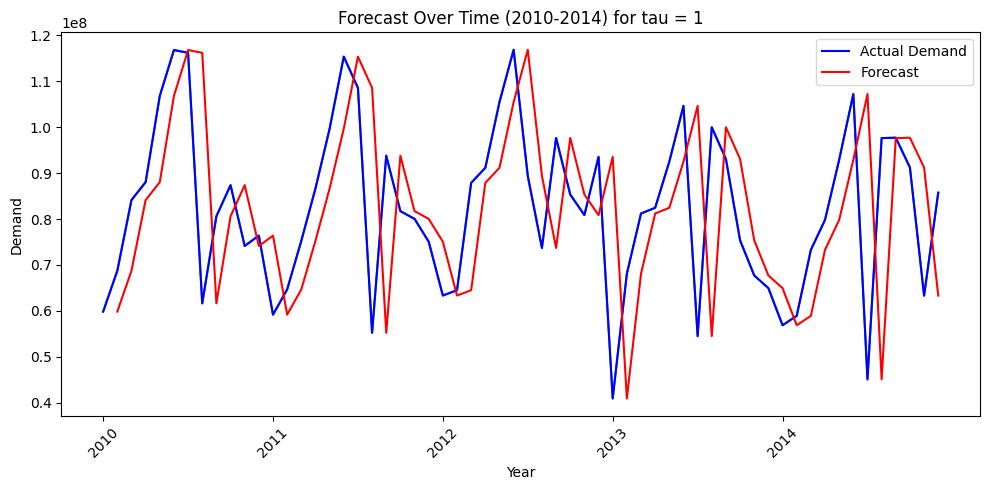

In [312]:
forecast = get_naive_F_series(1, demand)
plt.figure(figsize=(10, 5))
plt.plot(demand)
plt.xticks(range(0, len(df["Year"]), 12), df["Year"].unique(), rotation=45)
plt.title(f"Forecast Over Time (2010-2014) for tau = 1")
plt.xlabel("Year")
plt.ylabel("Demand")
plt.tight_layout()
plt.plot(df["Demand"], color="blue", label="Actual Demand")
plt.plot(forecast, color="red", label="Forecast")
plt.legend()

Naive Forecast for Tau = 12

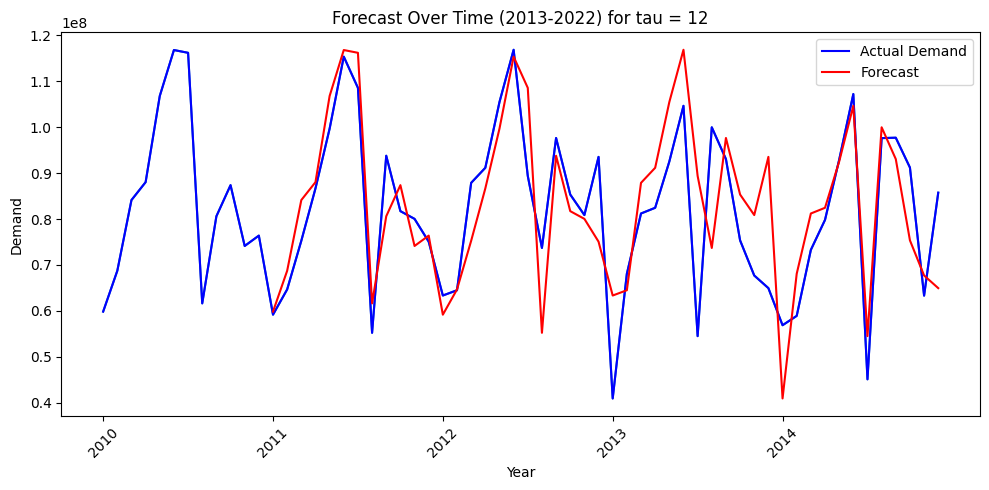

In [313]:
forecast = get_naive_F_series(12, demand)
plt.figure(figsize=(10, 5))
plt.plot(demand)
plt.xticks(range(0, len(df["Year"]), 12), df["Year"].unique(), rotation=45)
plt.title(f"Forecast Over Time (2013-2022) for tau = 12")
plt.xlabel("Year")
plt.ylabel("Demand")
plt.tight_layout()
plt.plot(demand, color="blue", label="Actual Demand")
plt.plot(forecast, color="red", label="Forecast")
plt.legend()

Error Metrics for Tau = 1 and Tau = 12

In [314]:
for tau in [1, 12]:
    forecast = get_naive_F_series(tau, demand)
    mae = mean_absolute_error(demand, forecast, 2011, 2014, 2)
    mape = mean_abs_percentage_error(demand, forecast, 2011, 2014, 2)
    rmse = root_mean_squared_error(demand, forecast, 2011, 2014, 2)
    print(f"For tau = {tau}:")
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Absolute Percentage Error (MAPE):", mape)
    print("Root Mean Squared Error (RMSE):", rmse)

For tau = 1:
Mean Absolute Error (MAE): 17286475.833333332
Mean Absolute Percentage Error (MAPE): 24.533132381898707
Root Mean Squared Error (RMSE): 23299270.417937733
For tau = 12:
Mean Absolute Error (MAE): 9104424.75
Mean Absolute Percentage Error (MAPE): 12.501022374181906
Root Mean Squared Error (RMSE): 12085064.922952536


# PART C

Residuals

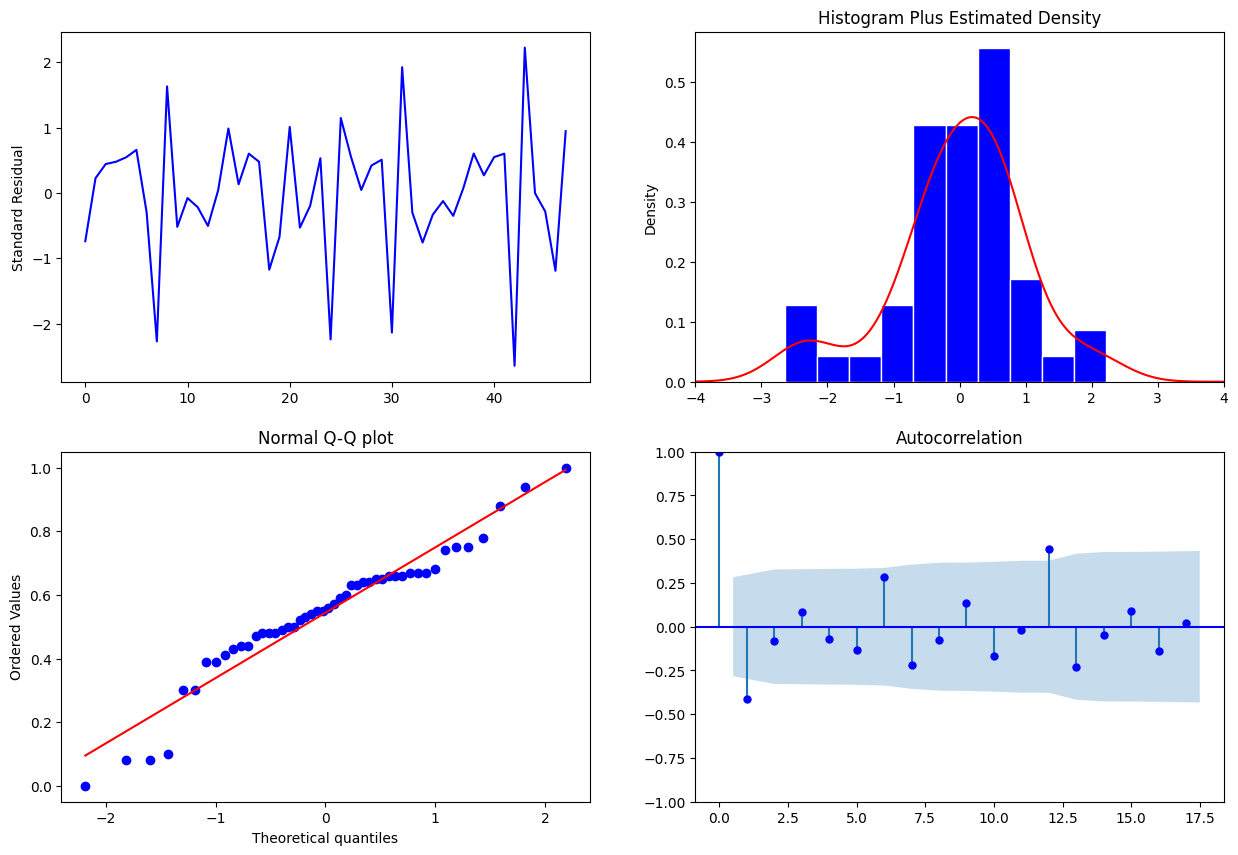

For tau = 1
Fail to reject the null hypothesis. The mean of residuals could plausibly be zero.


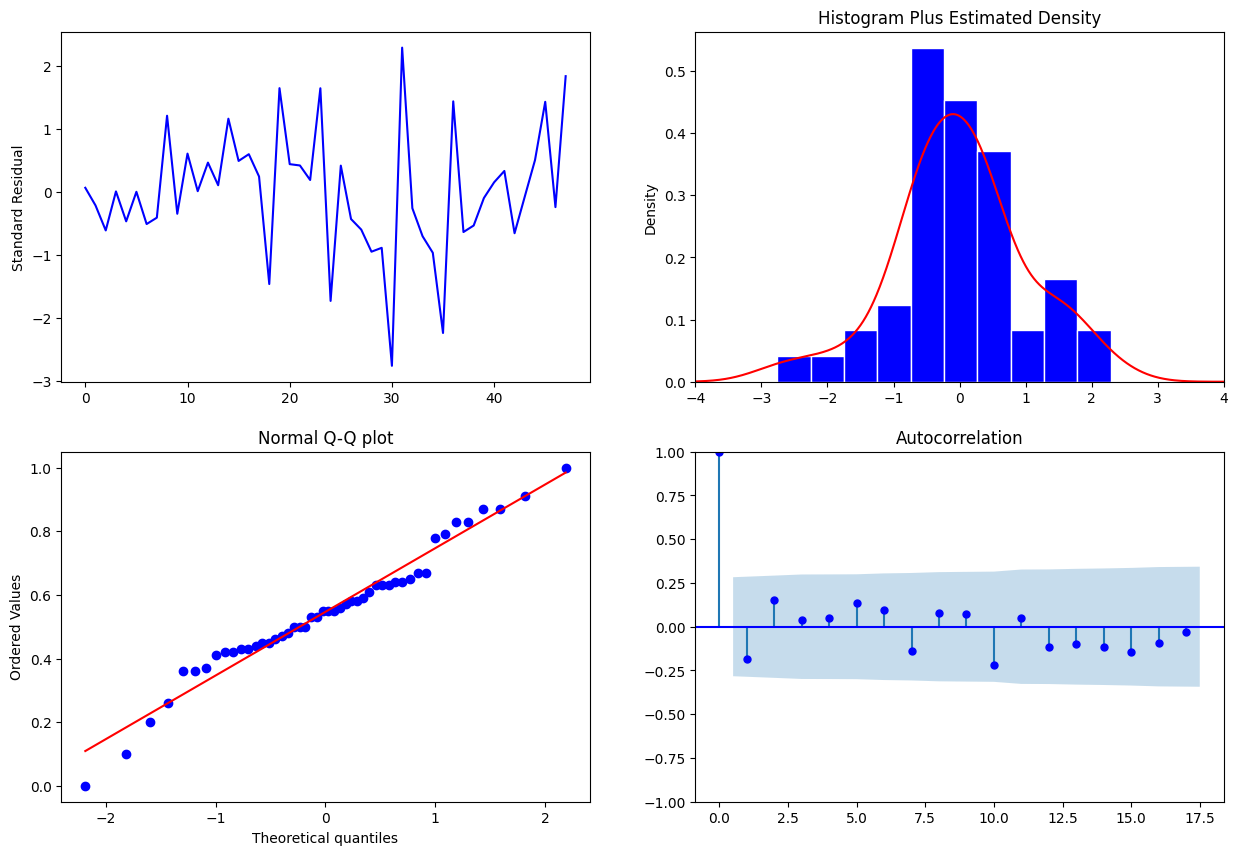

For tau = 12
Fail to reject the null hypothesis. The mean of residuals could plausibly be zero.


In [315]:
for tau in [1, 12]:
    forecast = get_naive_F_series(tau, demand)
    residuals = get_residuals(demand, forecast, 2011, 2014, 2)
    bijan.eplot(residuals)
    print(f"For tau = {tau}")
    print(test_residual_mean(residuals))

# PART D

# Triple Exponential Smoothing (Holt-Winters) (Multiplicative)

### $F_{t} = (S_{t- \tau} + \tau G_{t- \tau})c_{t - N}$
### $S_{t} = \alpha \frac{D_{t}}{c_{t-N}} + (1-\alpha)(S_{t-1} + G_{t-1})$
### $G_{t} = \beta(S_{t} - S_{t-1}) + (1-\beta)G_{t-1}$
### $c_{t} = \gamma \frac{D_{t}}{S_{t}} + (1-\gamma)c_{t-N}$

In [316]:
# triple expontial smoothing ps version
def find_c_t(gamma: float, N: int, results: pd.DataFrame, t: int) -> float:
    """
    Calculate c_t
    :param gamma: float, smoothing parameter for seasonality
    :param N: int, number of seasonal periods
    :param results: pd.DataFrame, results of the Holt-Winters model
    :param t: int, index of the current period
    :return: float, c_t
    """
    # initialization rule
    if t <= N:
        return results.loc[t, "D_t"] / np.mean(results.loc[:N, "D_t"])
    # normal calculation
    else:
        return (
            gamma * (results.loc[t, "D_t"] / results.loc[t, "S_t"])
            + (1 - gamma) * results.loc[t - N, "c_t"]
        )


def find_S_t(alpha: float, N: int, results: pd.DataFrame, t: int) -> float:
    """
    Calculate S_t
    :param alpha: float, smoothing parameter for level
    :param N: int, number of seasonal periods
    :param results: pd.DataFrame, results of the Holt-Winters model
    :param t: int, index of the current period
    :return: float, S_t
    """
    # initialization rule
    if t == N + 1:
        return results.loc[t, "D_t"] / results.loc[t - N, "c_t"]
    # normal calculation
    else:
        return alpha * (results.loc[t, "D_t"] / results.loc[t - N, "c_t"]) + (
            1 - alpha
        ) * (results.loc[t - 1, "S_t"] + results.loc[t - 1, "G_t"])


def find_G_t(beta: float, N: int, results: pd.DataFrame, t: int) -> float:
    """
    Calculate G_t
    :param beta: float, smoothing parameter for trend
    :param N: int, number of seasonal periods
    :param results: pd.DataFrame, results of the Holt-Winters model
    :param t: int, index of the current period
    :return: float, G_t
    """
    # initialization rule
    if t == N + 1:
        return results.loc[t, "S_t"] - (
            results.loc[t - 1, "D_t"] / results.loc[t - 1, "c_t"]
        )
    # normal calculation
    else:
        return (
            beta * (results.loc[t, "S_t"] - results.loc[t - 1, "S_t"])
            + (1 - beta) * results.loc[t - 1, "G_t"]
        )


def find_F_t(tau: int, N: int, results: pd.DataFrame, t: int, data_len: int) -> float:
    """
    Calculate F_t
    :param results: pd.DataFrame, results of the Holt-Winters model
    :param t: int, index of the current period
    :param N: int, number of seasonal periods
    :param tau: int, forecast horizon
    :param data_len: int, length of the time series
    :return: float, F_t
    """

    c_index = t - N
    if c_index > data_len:
        c_index = data_len

    S_index = t - tau
    if S_index > data_len:
        S_index = data_len

    G_index = t - tau
    if G_index > data_len:
        G_index = data_len

    return (
        results.loc[S_index, "S_t"] + tau * results.loc[G_index, "G_t"]
    ) * results.loc[c_index, "c_t"]


def triple_exp_smoothing(
    alpha: float,
    beta: float,
    gamma: float,
    N: int,
    max_forecast_horizon: int,
    data: list,
) -> list[float]:
    """
    Holt-Winters Triple Exponential Smoothing (Multiplicative)
    :param alpha: float, smoothing parameter for level
    :param beta: float, smoothing parameter for trend
    :param gamma: float, smoothing parameter for seasonality
    :param N: int, number of seasonal periods
    :param max_forecast_horizon: int, maximum number of periods to forecast
    :param data: list, time series to forecast
    :return: pd.Series, forecast
    """

    # create a dataframe to store the results
    # dataframe has 6 columns: t, D_t, S_t, G_t, c_t, F_t
    results = pd.DataFrame(
        columns=["t", "D_t", "S_t", "G_t", "c_t", "F_t"], index=range(1, len(data) + 1)
    )

    # put the time series into a dataframe
    results["t"] = range(1, len(data) + 1)
    results["D_t"] = data

    length_of_data = len(data)

    for t in results["t"].tolist():

        # if 't' is less than N, we should first initialize c_t
        if t <= N:
            results.loc[t, "c_t"] = find_c_t(gamma, N, results, t)

        # if 't' is equal to N, we should first initialize S_t and G_t
        elif t == N + 1:
            results.loc[t, "S_t"] = find_S_t(alpha, N, results, t)
            results.loc[t, "G_t"] = find_G_t(beta, N, results, t)
            results.loc[t, "c_t"] = find_c_t(gamma, N, results, t)

        # if 't' is greater than N, we can calculate S_t, G_t, and c_t
        # and then calculate F_t
        else:
            results.loc[t, "S_t"] = find_S_t(alpha, N, results, t)
            results.loc[t, "G_t"] = find_G_t(beta, N, results, t)
            results.loc[t, "c_t"] = find_c_t(gamma, N, results, t)
            results.loc[t, "F_t"] = find_F_t(1, N, results, t, length_of_data)

    # add forecast values to the results dataframe
    for tau in range(1, max_forecast_horizon + 1):
        new_row = [len(data) + tau + 1, np.nan, np.nan, np.nan, np.nan, np.nan]
        results.loc[len(data) + tau + 1] = new_row

        results.loc[len(data) + tau + 1, "F_t"] = find_F_t(
            tau, N, results, len(data) + tau, length_of_data
        )
    results["t"] = results["t"].astype(int)

    forecasts = results["F_t"].tolist()

    return forecasts

In [317]:
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
beta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
gamma_values = [0.1, 0.5, 0.9]
N = 12
# Initialize variables to store error metrics and prediction intervals
best_mape = float('inf')
best_rmse = float('inf')
best_mae = float('inf')
best_forecast = None
best_alpha = None
best_beta = None
best_gamma = None
prediction_intervals = []

# Loop through different values of alpha, beta, and gamma
for alpha in alpha_values:
    for beta in beta_values:
        for gamma in gamma_values:
            forecast = triple_exp_smoothing(alpha, beta, gamma, N, 1, demand.to_list())

            mape = mean_abs_percentage_error(demand, forecast, 2012, 2014, 2)
            rmse = root_mean_squared_error(demand, forecast, 2012, 2014, 2)
            mae = mean_absolute_error(demand, forecast, 2012, 2014, 2)

            if mape < best_mape:
                best_mape = mape
                best_mape_forecast = forecast
                best_alpha_mape = alpha
                best_beta_mape = beta
                best_gamma_mape = gamma

            if mae < best_mae:
                best_mae = mae
                best_mae_forecast = forecast
                best_alpha_mae = alpha
                best_beta_mae = beta
                best_gamma_mae = gamma

            if rmse < best_rmse:
                best_rmse = rmse
                best_rmse_forecast = forecast
                best_alpha_rmse = alpha
                best_beta_rmse = beta
                best_gamma_rmse = gamma

print("Best Smoothing Constants:")
print("\nBest MAPE:", best_mape)
print("Corresponding Alpha (MAPE):", best_alpha_mape)
print("Corresponding Beta (MAPE):", best_beta_mape)
print("Corresponding Gamma (MAPE):", best_gamma_mape)

print("\nBest MAE:", best_mae)
print("Corresponding Alpha (MAE):", best_alpha_mae)
print("Corresponding Beta (MAE):", best_beta_mae)
print("Corresponding Gamma (MAE):", best_gamma_mae)

print("\nBest RMSE:", best_rmse)
print("Corresponding Alpha (RMSE):", best_alpha_rmse)
print("Corresponding Beta (RMSE):", best_beta_rmse)
print("Corresponding Gamma (RMSE):", best_gamma_rmse)


Best Smoothing Constants:

Best MAPE: 13.439903421307337
Corresponding Alpha (MAPE): 0.1
Corresponding Beta (MAPE): 0.4
Corresponding Gamma (MAPE): 0.9

Best MAE: 9619281.001392981
Corresponding Alpha (MAE): 0.1
Corresponding Beta (MAE): 0.4
Corresponding Gamma (MAE): 0.9

Best RMSE: 13397575.39660953
Corresponding Alpha (RMSE): 0.1
Corresponding Beta (RMSE): 0.1
Corresponding Gamma (RMSE): 0.9


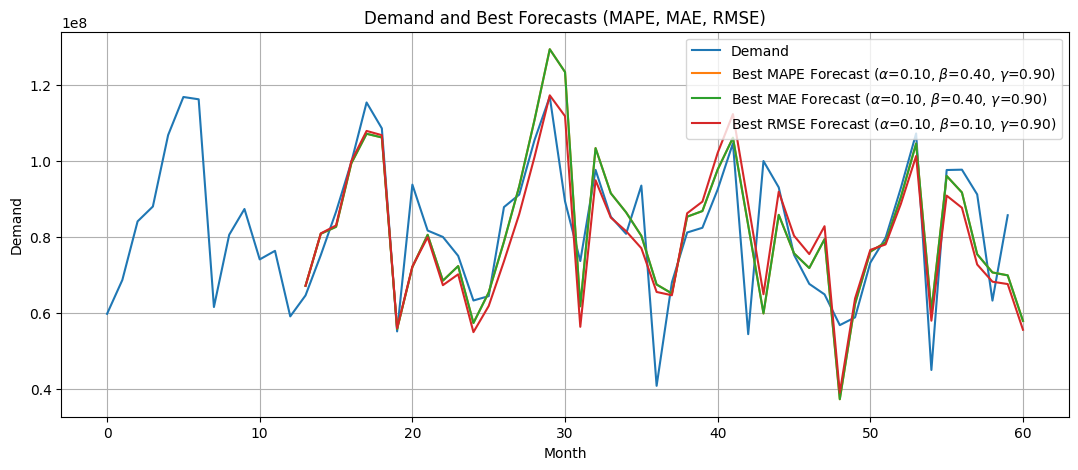

In [318]:
plt.figure(figsize=(13, 5))
plt.plot(demand, label="Demand")

alpha_latex = r"$\alpha$"
beta_latex = r"$\beta$"
gamma_latex = r"$\gamma$"

plt.plot(best_mape_forecast, label=f"Best MAPE Forecast ({alpha_latex}={best_alpha_mape:.2f}, {beta_latex}={best_beta_mape:.2f}, {gamma_latex}={best_gamma_mape:.2f})", linestyle='-')
plt.plot(best_mae_forecast, label=f"Best MAE Forecast ({alpha_latex}={best_alpha_mae:.2f}, {beta_latex}={best_beta_mae:.2f}, {gamma_latex}={best_gamma_mae:.2f})", linestyle='-')
plt.plot(best_rmse_forecast, label=f"Best RMSE Forecast ({alpha_latex}={best_alpha_rmse:.2f}, {beta_latex}={best_beta_rmse:.2f}, {gamma_latex}={best_gamma_rmse:.2f})", linestyle='-')

plt.title("Demand and Best Forecasts (MAPE, MAE, RMSE)")
plt.xlabel("Month")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()


Prediction Intervals

In [319]:
best_forecast = best_rmse_forecast
std_estimator = root_mean_squared_error(demand, best_forecast, 2011, 2013, 2)
intervals = get_pred_interval_list(best_forecast, 0.9, std_estimator, 2014, 2)
lower_bound = [interval[0] for interval in intervals]
upper_bound = [interval[1] for interval in intervals]

print(f"90 percent prediction intervals for the one-month ahead forecasts using triple exponential smoothing (alpha = {best_alpha_rmse}, beta = {best_beta_rmse}, gamma = {best_gamma_rmse}):")
for interval in intervals:
    print(interval)

90 percent prediction intervals for the one-month ahead forecasts using triple exponential smoothing (alpha = 0.1, beta = 0.1, gamma = 0.9):
(17913532.42868094, 60307417.56238669)
(42665451.67488194, 85059336.8085877)
(55441064.9439921, 97834950.07769784)
(56870659.73097909, 99264544.86468485)
(67515919.91953641, 109909805.05324215)
(80103845.09170252, 122497730.22540826)
(36832381.385113776, 79226266.51881953)
(69691250.69648412, 112085135.83018985)
(66507308.265390776, 108901193.39909652)
(51595428.10890535, 93989313.24261111)
(47078805.50377046, 89472690.6374762)
(46455954.95928306, 88849840.09298882)


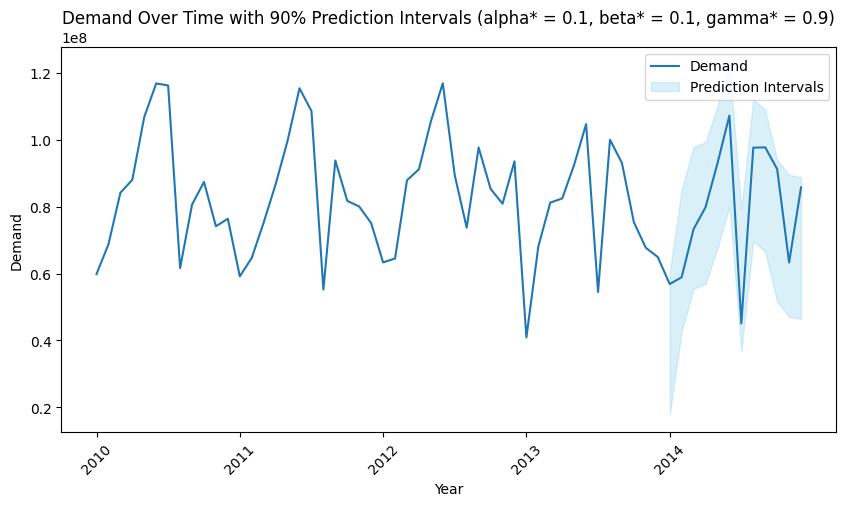

In [322]:
lower_bound = [interval[0] for interval in intervals]
upper_bound = [interval[1] for interval in intervals]
plt.figure(figsize=(10, 5))
plt.plot(demand, label='Demand')
plt.fill_between(range(4 * 12, len(lower_bound) + 4 * 12 ), lower_bound, upper_bound, color='skyblue', alpha=0.3, label='Prediction Intervals')
plt.xticks(range(0, len(df['Year']), 12), df['Year'].unique(), rotation=45)
plt.title(f'Demand Over Time with 90% Prediction Intervals (alpha* = {best_alpha_rmse}, beta* = {best_beta_rmse}, gamma* = {best_gamma_rmse})')
plt.xlabel('Year')
plt.ylabel('Demand')
plt.legend()
plt.show()

# Part E

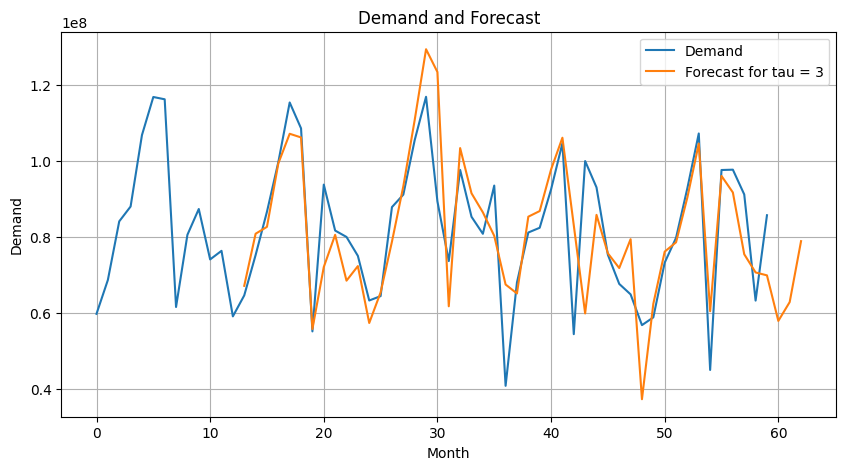

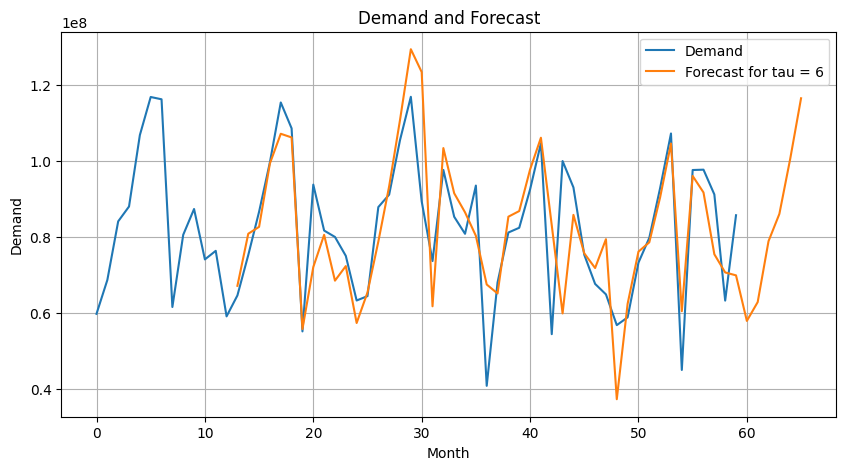

In [321]:
alpha = best_alpha_mape
beta = best_beta_mape
gamma = best_gamma_mape
for tau in [3, 6]:
    forecast = triple_exp_smoothing(alpha, beta, gamma, N, tau, demand.to_list())
    plt.figure(figsize=(10, 5))
    plt.plot(demand, label="Demand")
    plt.plot(forecast, label=f"Forecast for tau = {tau}")
    plt.title("Demand and Forecast")
    plt.xlabel("Month")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

        